In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

# score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [20]:
def create_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
#  model.add(Dense(12, activation='relu'))
 model.add(Dense(60, activation='relu'))
#  model.add(Dense(20, activation='relu'))
 model.add(Dropout(rate=0.2))
 model.add(Dense(10, activation='relu'))
 model.add(Dense(1))
 # Compile model
 model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
 return model

In [3]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [21]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 20, 'epochs': 100}
CV score for GS 0.8230442262731039
Train AUC ROC Score for GS:  0.8747921080114418
Test AUC ROC Score for GS:  0.868978255295895
Train Mean Absolute Error: 33399    0.068771
33689    0.296220
15746    0.143852
29123    0.020671
7868     0.125064
           ...   
28017    0.047339
50496    0.115201
29199    0.356961
40061    0.141767
17673    0.150412
Name: LUMO_calc, Length: 41004, dtype: float64 degrees.
Test Mean Absolute Error: 29860    0.080377
46773    0.328464
35540    0.687901
42760    0.075365
19319    0.078352
           ...   
27088    0.350704
26941    0.067178
46093    0.041595
19342    0.443944
47488    0.731802
Name: LUMO_calc, Length: 10252, dtype: float64 degrees.
Train R2:  0.8228664563531438
Test R2:  0.8112377462641004
Train MSE:  0.05240812612508098
Test MSE:  0.05617896455023825


In [4]:
def create_new_model():
 # create model
 model = Sequential()
 model.add(Dense(29, input_shape=(29,), activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(30, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dropout(rate=0.2))
 model.add(BatchNormalization())
 model.add(Dense(10, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(1))
 # Compile model
 model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
 return model

In [5]:
seed = 7
tf.random.set_seed(seed)
# load dataset
# create model
model = KerasRegressor(model=create_new_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid_cv = grid.fit(X_train, y_train)
# summarize results
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print('Test Mean Absolute Error:', abs(grid_cv.predict(X_test) - y_test), 'degrees.')

# prediction = model.predict(X_test)
# mse = mean_squared_error(y_test, prediction)
# #calculate R-squared of regression model
# r_squared = model.score(X_test, y_test)

#view R-squared value
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'batch_size': 80, 'epochs': 100}
CV score for GS 0.8183805289795674
Train AUC ROC Score for GS:  0.8686261529464534
Test AUC ROC Score for GS:  0.8648900906573395
Train Mean Absolute Error: 33399    0.197348
33689    0.207521
15746    0.154289
29123    0.029123
7868     0.233069
           ...   
28017    0.095370
50496    0.230497
29199    0.270170
40061    0.024812
17673    0.340330
Name: LUMO_calc, Length: 41004, dtype: float64 degrees.
Test Mean Absolute Error: 29860    0.076758
46773    0.446046
35540    0.718989
42760    0.058251
19319    0.147516
           ...   
27088    0.411433
26941    0.030661
46093    0.020417
19342    0.465848
47488    0.605175
Name: LUMO_calc, Length: 10252, dtype: float64 degrees.
Train R2:  0.8277081788626701
Test R2:  0.8198344069875744
Train MSE:  0.050975615948195566
Test MSE:  0.053620447217052704


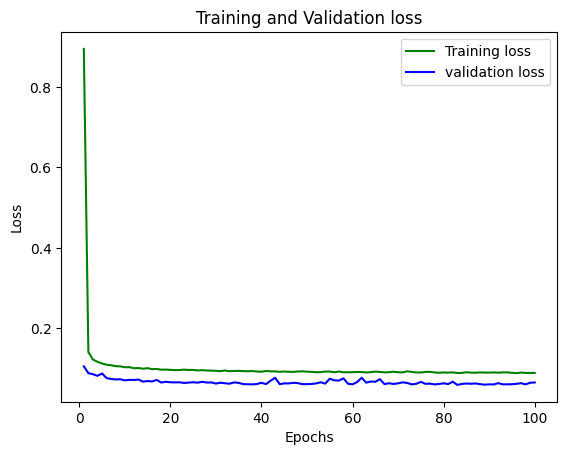

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val))
loss_train = model.history_['loss']
loss_val = model.history_['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()